In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
import os.path
path = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007'
num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
print(num_files)

In [ ]:
import os
import cv2
images = np.zeros((25000, 224, 224, 3))
labels = np.zeros(25000)
folder = '/kaggle/working/train'
i = 1
print('Importing images...')
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, filename))
    if img is not None:
        images[i-1] = cv2.resize(img, (112, 112))/255.0
        print(f'Image {i}/25000 imported successfully!', end='\r')
        if 'cat' in filename:
            labels[i-1] = 1
        else:
            labels[i-1] = 0
        i+=1

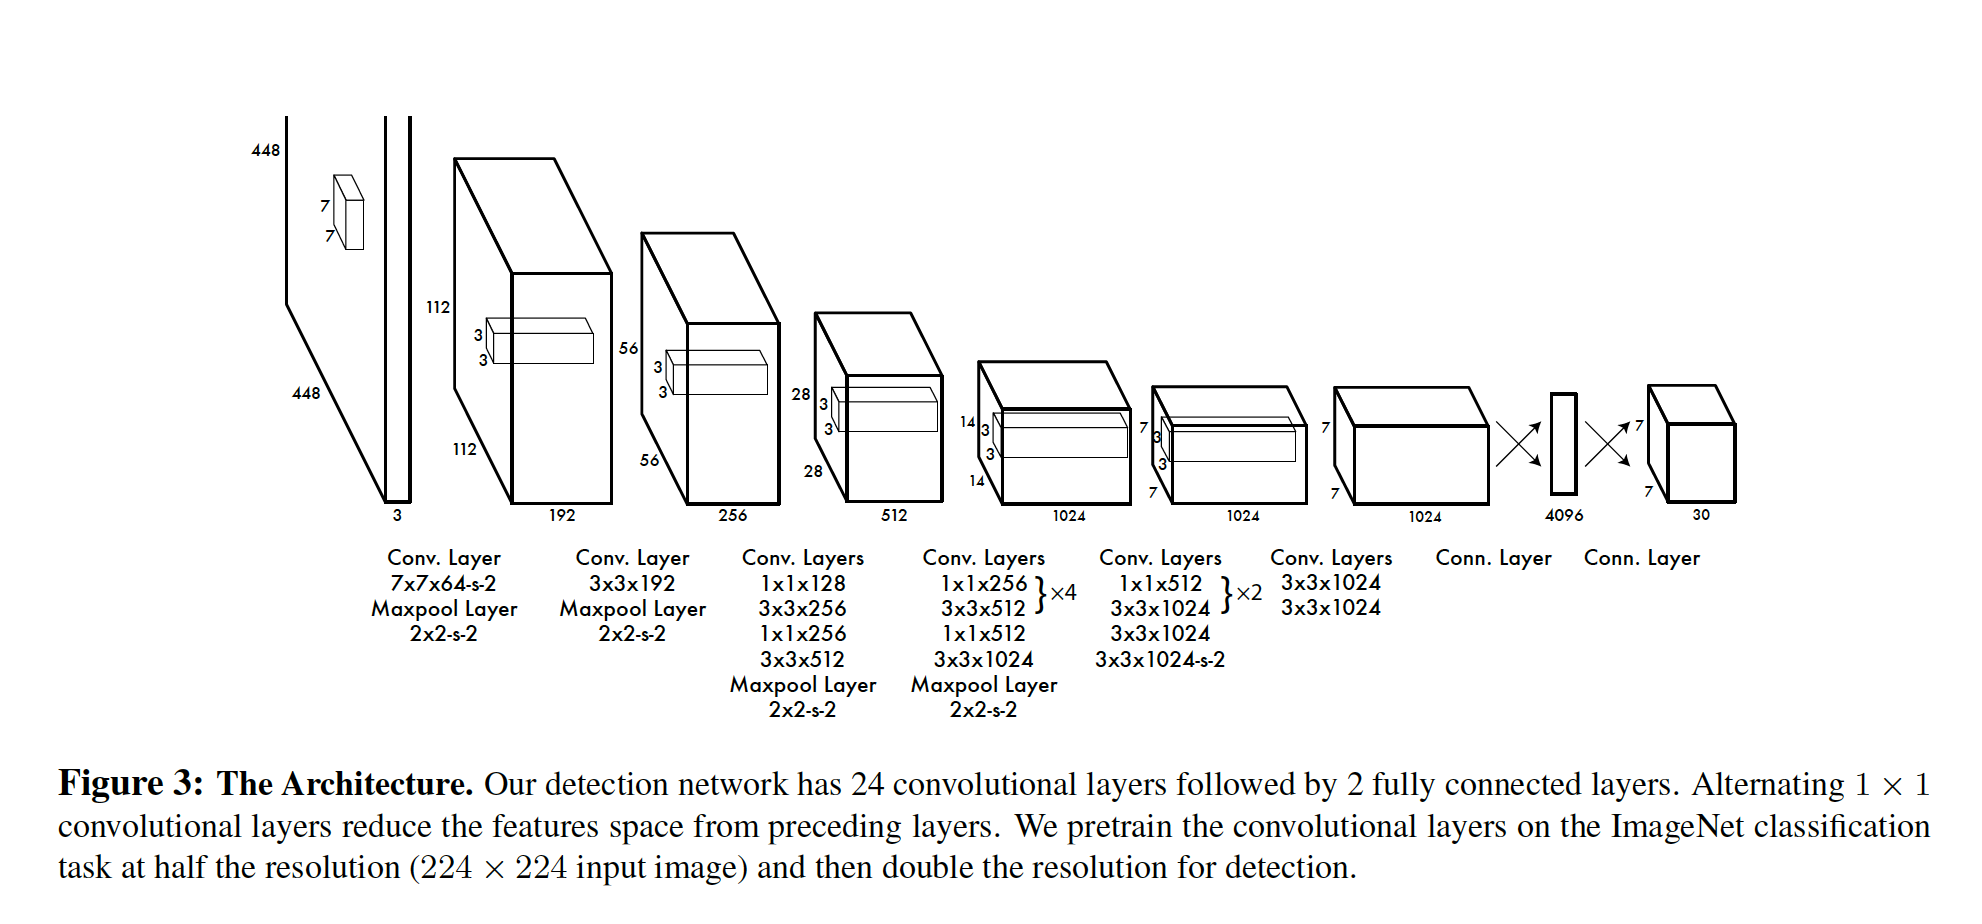

In [ ]:
import keras.backend as K

class Yolo_Reshape(tf.keras.layers.Layer):
  def __init__(self, target_shape):
    super(Yolo_Reshape, self).__init__()
    self.target_shape = tuple(target_shape)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'target_shape': self.target_shape
    })
    return config

  def call(self, input):
    # grids 7x7
    S = [self.target_shape[0], self.target_shape[1]]
    # classes
    C = 20
    # no of bounding boxes per grid
    B = 2

    idx1 = S[0] * S[1] * C
    idx2 = idx1 + S[0] * S[1] * B
    
    # class probabilities
    class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))
    class_probs = K.softmax(class_probs)

    #confidence
    confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
    confs = K.sigmoid(confs)

    # boxes
    boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
    boxes = K.sigmoid(boxes)

    outputs = K.concatenate([class_probs, confs, boxes])
    return outputs

In [ ]:
# Model implementation
input = keras.Input(shape=(224, 224, 3))
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01)
lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)
x = layers.Conv2D(filters=64,kernel_size=(7, 7),strides=2, activation=lrelu,padding='same')(input)
x = layers.MaxPooling2D(pool_size=(2,2),strides=2)(x)

x = layers.Conv2D(filters=192,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2,2),strides=2)(x)


x = layers.Conv2D(filters=128,kernel_size=(1, 1),strides=1, activation=lrelu,padding='same')(x)
x = layers.Conv2D(filters=256,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)
x = layers.Conv2D(filters=256,kernel_size=(1, 1),strides=1, activation=lrelu,padding='same')(x)
x = layers.Conv2D(filters=512,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2,2),strides=2)(x)

for i in range(4):
    x = layers.Conv2D(filters=256,kernel_size=(1, 1),strides=1, activation=lrelu,padding='same')(x)
    x = layers.Conv2D(filters=512,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)
x = layers.Conv2D(filters=512,kernel_size=(1, 1),strides=1, activation=lrelu,padding='same')(x)
x = layers.Conv2D(filters=1024,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2,2),strides=2)(x)

for i in range(2):
    x = layers.Conv2D(filters=512,kernel_size=(1, 1),strides=1, activation=lrelu,padding='same')(x)
    x = layers.Conv2D(filters=1024,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)
x = layers.Conv2D(filters=1024,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)
x = layers.Conv2D(filters=1024,kernel_size=(3, 3),strides=2, activation=lrelu,padding='same')(x)

x = layers.Conv2D(filters=1024,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)
x = layers.Conv2D(filters=1024,kernel_size=(3, 3),strides=1, activation=lrelu,padding='same')(x)

# Fully-connected layer
x = layers.Flatten()(x)
x = layers.Dense(4096, activation=lrelu, use_bias=True, kernel_initializer=initializer, bias_initializer=keras.initializers.Zeros())(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1470, use_bias=True, kernel_initializer=initializer, bias_initializer=keras.initializers.Zeros())(x)
output = Yolo_Reshape(target_shape=(7,7,30))(x)

model = keras.Model(inputs=input, outputs=output, name="Yolov1_model")
model.summary()


In [ ]:
# Import custom loss function for Yolo
import keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

In [ ]:
model.compile(
    loss=yolo_loss,
    optimizer=keras.optimizers.Adam()
)
# model.fit(x_train, y_train, batch_size=48, epochs=10, validation_split=0.2)